# MLB Predictor

In [1]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt  
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Loading and Processing Data from SQL DataBase

In [2]:
conn = sqlite3.connect('sql_data/lahman2016.sqlite')
query = '''select * from Teams 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == 'Y';
'''


In [3]:
Teams = conn.execute(query).fetchall()
teams_df = pd.DataFrame(Teams)
print(teams_df.head())

     0   1    2    3     4   5    6     7   8   9   ...        42   43   44  \
0  1961  AL  LAA  ANA  None   8  162  82.0  70  91  ...    603510  111  112   
1  1962  AL  LAA  ANA  None   3  162  81.0  86  76  ...   1144063   97   97   
2  1963  AL  LAA  ANA  None   9  161  81.0  70  91  ...    821015   94   94   
3  1964  AL  LAA  ANA  None   5  162  81.0  82  80  ...    760439   90   90   
4  1965  AL  CAL  ANA  None   7  162  80.0  75  87  ...    566727   97   98   

    45   46   47   48                             49  50    51  
0  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
1  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
2  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
3  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
4  CAL  CAL  CAL  ANA  Los Angeles Angels of Anaheim   Y  None  

[5 rows x 52 columns]


In [4]:
cols = ['yearID','lgID','teamID','franchID','divID','Rank','G','Ghome','W','L','DivWin','WCWin','LgWin','WSWin','R','AB','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
teams_df.columns = cols

print(teams_df.head())

print(len(teams_df))

   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L   ...     \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91   ...      
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76   ...      
2    1963   AL    LAA       ANA  None     9  161   81.0  70  91   ...      
3    1964   AL    LAA       ANA  None     5  162   81.0  82  80   ...      
4    1965   AL    CAL       ANA  None     7  162   80.0  75  87   ...      

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro  franchID  \
0     603510  111  112      LAA             LAA          LAA       ANA   
1    1144063   97   97      LAA             LAA          LAA       ANA   
2     821015   94   94      LAA             LAA          LAA       ANA   
3     760439   90   90      LAA             LAA          LAA       ANA   
4     566727   97   98      CAL             CAL          CAL       ANA   

                      franchName  active  NAassoc  
0  Los Angeles Angels of Anaheim       Y     N

In [5]:
drop_cols = ['lgID','franchID','divID','Rank','Ghome','L','DivWin','WCWin','LgWin','WSWin','SF','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']

df = teams_df.drop(drop_cols, axis=1)

print(df.head())

   yearID teamID    G   W    R    AB     H   2B  3B   HR  ...    SHO  SV  \
0    1961    LAA  162  70  744  5424  1331  218  22  189  ...      5  34   
1    1962    LAA  162  86  718  5499  1377  232  35  137  ...     15  47   
2    1963    LAA  161  70  597  5506  1378  208  38   95  ...     13  31   
3    1964    LAA  162  82  544  5362  1297  186  27  102  ...     28  41   
4    1965    CAL  162  75  527  5354  1279  200  36   92  ...     14  33   

   IPouts    HA  HRA  BBA  SOA    E     DP     FP  
0    4314  1391  180  713  973  192  154.0  0.969  
1    4398  1412  118  616  858  175  153.0  0.972  
2    4365  1317  120  578  889  163  155.0  0.974  
3    4350  1273  100  530  965  138  168.0  0.978  
4    4323  1259   91  563  847  123  149.0  0.981  

[5 rows x 29 columns]


In [6]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 419, 1777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


In [7]:
df = df.drop(['CS','HBP'], axis=1)

df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Visualize processed Data

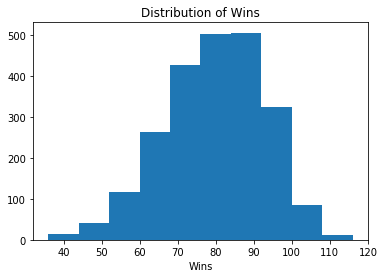

The Mean Distribution of Wins:  79.23043288150416


In [8]:
plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Distribution of Wins')

plt.show()
print("The Mean Distribution of Wins: ", df['W'].mean())

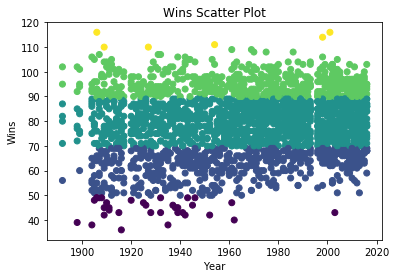

In [9]:
def assign_win_bins(W):
    if W < 50:
        return 1
    if W >= 50 and W <= 69:
        return 2
    if W >= 70 and W <= 89:
        return 3
    if W >= 90 and W <= 109:
        return 4
    if W >= 110:
        return 5
    
df['win_bins'] = df['W'].apply(assign_win_bins)

plt.scatter(df['yearID'], df['W'], c=df['win_bins'])
plt.title('Wins Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Wins')

plt.show()

In [10]:
df = df[df['yearID'] > 1900]

runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games
        
print(runs_per_year)
print(games_per_year)

{1961: 12942, 1962: 14461, 1963: 12780, 1964: 13124, 1965: 12946, 1966: 12900, 1967: 12210, 1968: 11109, 1969: 15850, 1970: 16880, 1971: 15073, 1972: 13706, 1973: 16376, 1974: 16046, 1975: 16295, 1976: 15492, 1977: 18803, 1978: 17251, 1979: 18713, 1980: 18053, 1982: 18110, 1983: 18170, 1984: 17921, 1985: 18216, 1986: 18545, 1987: 19883, 1988: 17380, 1989: 17405, 1990: 17919, 1991: 18127, 1992: 17341, 1993: 20864, 1996: 22831, 1997: 21604, 1998: 23297, 1999: 24691, 2000: 24971, 2001: 23199, 2002: 22408, 2003: 22978, 2004: 23376, 2005: 22325, 2006: 23599, 2007: 23322, 2008: 22585, 2009: 22419, 2010: 21308, 2011: 20808, 2012: 21017, 2013: 20255, 2014: 19761, 2015: 20647, 2016: 21744, 1904: 9307, 1905: 9640, 1906: 8322, 1907: 8186, 1908: 8423, 1909: 8805, 1910: 9580, 1911: 11164, 1912: 11154, 1913: 9964, 1914: 9408, 1915: 9444, 1916: 8889, 1917: 8948, 1920: 10762, 1921: 11935, 1922: 12059, 1923: 11874, 1924: 11722, 1925: 12596, 1926: 11443, 1927: 11745, 1928: 11645, 1929: 12747, 1930: 1369

In [11]:
mlb_runs_per_game = {}
for k, v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs / games
    
print(mlb_runs_per_game)

{1961: 4.525174825174825, 1962: 4.460518198642813, 1963: 3.9468807906114884, 1964: 4.035670356703567, 1965: 3.9882932840418976, 1966: 3.9938080495356036, 1967: 3.7685185185185186, 1968: 3.4181538461538463, 1969: 4.07245632065776, 1970: 4.341563786008231, 1971: 3.8888028895768834, 1972: 3.6863905325443787, 1973: 4.214101904271745, 1974: 4.124935732647815, 1975: 4.21277145811789, 1976: 3.99484270242393, 1977: 4.470518307180218, 1978: 4.103472882968601, 1979: 4.457598856598381, 1980: 4.2881235154394295, 1982: 4.297579496915045, 1983: 4.307728781412992, 1984: 4.256769596199525, 1985: 4.330955777460771, 1986: 4.409177365668093, 1987: 4.722802850356294, 1988: 4.1380952380952385, 1989: 4.132241215574549, 1990: 4.256294536817102, 1991: 4.307747148288973, 1992: 4.1170465337132, 1993: 4.597620096959012, 1996: 5.0355094838994265, 1997: 4.766990291262136, 1998: 4.789679276315789, 1999: 5.0846375617792425, 2000: 5.140181144503911, 2001: 4.7754219843557015, 2002: 4.6183017312448476, 2003: 4.72798353

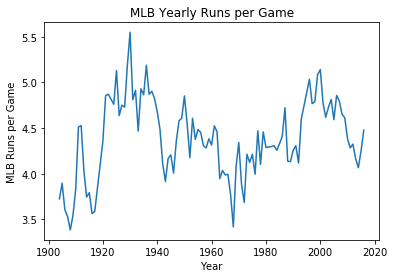

In [12]:
lists = sorted(mlb_runs_per_game.items())
x, y = zip(*lists)

plt.plot(x, y)
plt.title('MLB Yearly Runs per Game')
plt.xlabel('Year')
plt.ylabel('MLB Runs per Game')

plt.show()

In [13]:
def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8
        
# Add `year_label` column to `df`    
df['year_label'] = df['yearID'].apply(assign_label)

dummy_df = pd.get_dummies(df['year_label'], prefix='era')

# Concatenate `df` and `dummy_df`
df = pd.concat([df, dummy_df], axis=1)

print(df.head())

   yearID teamID    G   W    R    AB     H   2B  3B   HR  ...    win_bins  \
0    1961    LAA  162  70  744  5424  1331  218  22  189  ...           3   
1    1962    LAA  162  86  718  5499  1377  232  35  137  ...           3   
2    1963    LAA  161  70  597  5506  1378  208  38   95  ...           3   
3    1964    LAA  162  82  544  5362  1297  186  27  102  ...           3   
4    1965    CAL  162  75  527  5354  1279  200  36   92  ...           3   

   year_label  era_1  era_2  era_3  era_4  era_5  era_6  era_7  era_8  
0           4      0      0      0      1      0      0      0      0  
1           4      0      0      0      1      0      0      0      0  
2           5      0      0      0      0      1      0      0      0  
3           5      0      0      0      0      1      0      0      0  
4           5      0      0      0      0      1      0      0      0  

[5 rows x 37 columns]


In [14]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]

df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

In [15]:
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010
    
df['decade_label'] = df['yearID'].apply(assign_decade)
decade_df = pd.get_dummies(df['decade_label'], prefix='decade')
df = pd.concat([df, decade_df], axis=1)

# Drop unnecessary columns
df = df.drop(['yearID','year_label','decade_label'], axis=1)



In [16]:
df['R_per_game'] = df['R'] / df['G']
df['RA_per_game'] = df['RA'] / df['G']

Text(0.5,0,'Runs Allowed per Game')

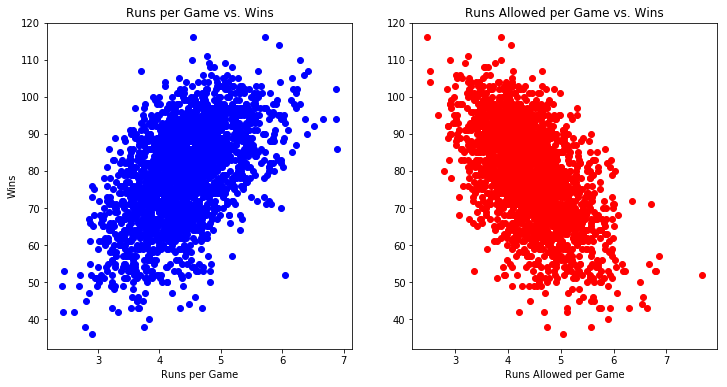

In [17]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'], df['W'], c='blue')
ax1.set_title('Runs per Game vs. Wins')
ax1.set_ylabel('Wins')
ax1.set_xlabel('Runs per Game')

ax2.scatter(df['RA_per_game'], df['W'], c='red')
ax2.set_title('Runs Allowed per Game vs. Wins')
ax2.set_xlabel('Runs Allowed per Game')

In [18]:
df.corr()['W']

G              0.178958
W              1.000000
R              0.551504
AB             0.233996
H              0.380281
2B             0.262323
3B             0.016970
HR             0.312713
BB             0.345348
SO             0.072069
SB             0.133300
RA            -0.518313
ER            -0.372580
ERA           -0.425833
CG            -0.041788
SHO            0.426892
SV             0.382174
IPouts         0.326087
HA            -0.384893
HRA            0.009880
BBA           -0.284782
SOA            0.259205
E             -0.304725
DP             0.015192
FP             0.319597
win_bins       0.912545
era_1         -0.077104
era_2         -0.083089
era_3         -0.033073
era_4         -0.052278
era_5          0.042122
era_6          0.058439
era_7          0.066049
era_8          0.043453
mlb_rpg        0.006909
decade_1910   -0.077104
decade_1920   -0.055176
decade_1930   -0.052358
decade_1940   -0.050249
decade_1950   -0.047499
decade_1960    0.028594
decade_1970    0

In [19]:
attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg']

data_attributes = df[attributes]

print(df.head())

  teamID    G   W    R    AB     H   2B  3B   HR   BB     ...       \
0    LAA  162  70  744  5424  1331  218  22  189  681     ...        
1    LAA  162  86  718  5499  1377  232  35  137  602     ...        
2    LAA  161  70  597  5506  1378  208  38   95  448     ...        
3    LAA  162  82  544  5362  1297  186  27  102  472     ...        
4    CAL  162  75  527  5354  1279  200  36   92  443     ...        

   decade_1940  decade_1950  decade_1960  decade_1970  decade_1980  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   decade_1990  decade_2000  decade_2010  R_per_game  RA_per_game  
0            0            0            0    4.592593     4.839506  
1            0        

### Model Data

In [20]:
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]

print(s_score_dict)

{2: [0.39069988022938779], 3: [0.33807585484810926], 4: [0.25340940061017997], 5: [0.23561577404187492], 6: [0.21388694120818219], 7: [0.19570350588885863], 8: [0.18660857478527421], 9: [0.17354548788709259], 10: [0.16986446409819547]}


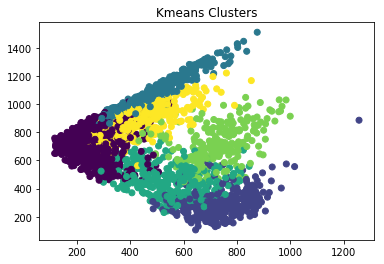

In [21]:
kmeans_model = KMeans(n_clusters=6, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')

plt.show()

In [22]:
df['labels'] = labels
attributes.append('labels')

print(df.head())

  teamID    G   W    R    AB     H   2B  3B   HR   BB   ...    decade_1950  \
0    LAA  162  70  744  5424  1331  218  22  189  681   ...              0   
1    LAA  162  86  718  5499  1377  232  35  137  602   ...              0   
2    LAA  161  70  597  5506  1378  208  38   95  448   ...              0   
3    LAA  162  82  544  5362  1297  186  27  102  472   ...              0   
4    CAL  162  75  527  5354  1279  200  36   92  443   ...              0   

   decade_1960  decade_1970  decade_1980  decade_1990  decade_2000  \
0            1            0            0            0            0   
1            1            0            0            0            0   
2            1            0            0            0            0   
3            1            0            0            0            0   
4            1            0            0            0            0   

   decade_2010  R_per_game  RA_per_game  labels  
0            0    4.592593     4.839506       5  
1         

In [23]:
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg','labels','W']
data = df[numeric_cols]
print(data.head())

# Split data DataFrame into train and test sets
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

x_train = train[attributes]
y_train = train['W']
x_test = test[attributes]
y_test = test['W']

     G    R    AB     H   2B  3B   HR   BB      SO   SB ...  decade_1970  \
0  162  744  5424  1331  218  22  189  681  1068.0   37 ...            0   
1  162  718  5499  1377  232  35  137  602   917.0   46 ...            0   
2  161  597  5506  1378  208  38   95  448   916.0   43 ...            0   
3  162  544  5362  1297  186  27  102  472   920.0   49 ...            0   
4  162  527  5354  1279  200  36   92  443   973.0  107 ...            0   

   decade_1980  decade_1990  decade_2000  decade_2010  R_per_game  \
0            0            0            0            0    4.592593   
1            0            0            0            0    4.432099   
2            0            0            0            0    3.708075   
3            0            0            0            0    3.358025   
4            0            0            0            0    3.253086   

   RA_per_game   mlb_rpg  labels   W  
0     4.839506  4.525175       5  70  
1     4.358025  4.460518       0  86  
2     4.099

In [25]:
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [27]:
predictions = lr.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
print(mae)

2.688790229


In [28]:
rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(x_train, y_train)

RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)

In [29]:
predictions_rrm = rrm.predict(x_test)
mae_rrm = mean_absolute_error(y_test, predictions_rrm)
print(mae_rrm)

2.67259187465
